## L-inf Norm attacks against CIFAR10

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (32,32,3)
num_classes = 10

# Load/Create Network and Generate Adversarial Data

In [3]:
#%%capture one
#Load model from disk
model_name = 'cifar10-resnet'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar10', transform='dct-3d',seed=SEED,project=False)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 200
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Learning rate:  0.001
Total Model Params: 273066
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

5000/5000 [==============================] - 2s 399us/step
Model Accuracy: 0.85540


In [4]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [5]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [6]:
%%capture four
import time
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
start_time = time.time()
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='FGSM')
print("--- JSMA: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
bim_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='BIM')
print("--- CW: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
#%%capture five
#reg_data = np.load('data/reg_data_cifar_li.npy')
#fgsm_data = np.load('data/fgsm_data_cifar_li.npy')
#bim_data = np.load('data/bim_data_cifar_li.npy')


In [9]:
%%capture five
np.save('data/reg_data_cifar_li', reg_data)
np.save('data/fgsm_data_cifar_li', fgsm_data)
np.save('data/bim_data_cifar_li', bim_data)

In [10]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM: %.5f' % (model.model.evaluate(fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM: %.5f' % (model.model.evaluate(bim_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 572s 572ms/step
Model Accuracy REG: 0.84600
1000/1000 [==============================] - 2s 2ms/step
Model Accuracy FGSM: 0.09300
1000/1000 [==============================] - 2s 2ms/step
Model Accuracy BIM: 0.07400


Training Data: 


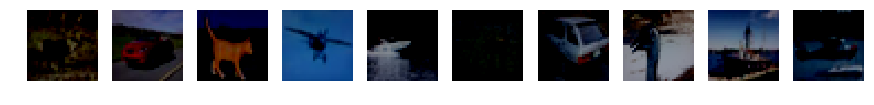

In [11]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-cifar_li')

Regular: 


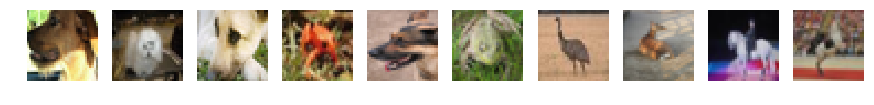

FGSM: 


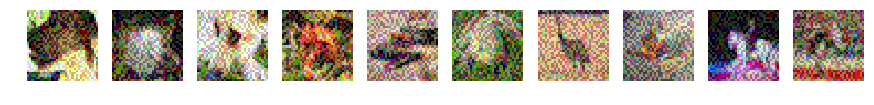

BIM: 


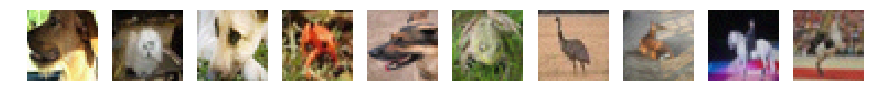

In [12]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-cifar_li')
print ('FGSM: ')
visualize(fgsm_data[x_vis].reshape(-1,*input_shape), 10, '../figures/fgsm-cifar_li')
print ('BIM: ')
visualize(bim_data[x_vis].reshape(-1,*input_shape), 10, '../figures/bim-cifar_li')

In [13]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_preds = model.model.predict(bim_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
fgsm_labels = preds_to_labels(fgsm_preds)
bim_labels = preds_to_labels(bim_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
fgsm_idx = np.where(np.argmax(fgsm_preds, axis=1) != true_preds)[0]
bim_idx = np.where(np.argmax(bim_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
fgsm_data_fil = fgsm_data[fgsm_idx]
bim_data_fil = bim_data[bim_idx]


#Filter labels to be used
fgsm_labels_fil = fgsm_labels[fgsm_idx]
bim_labels_fil = bim_labels[bim_idx]

In [14]:
def avg_linf_dist(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    linf_dist = 0.0
    num_ = orig.shape[0]
    if num_ > 0:
        for i in range(orig.shape[0]):
            linf_dist+= np.linalg.norm(orig[i].flatten() - adv[i].flatten(),ord=np.inf)
        return linf_dist/orig.shape[0]
    else:
        return np.nan

In [15]:
#Get l-inf distortion 
print ('FGSM: %.5f' % (avg_linf_dist(reg_data[fgsm_idx], fgsm_data_fil)))
print ('BIM: %.5f' % (avg_linf_dist(reg_data[bim_idx], bim_data_fil)))

FGSM: 0.15000
BIM: 0.01500


## DANTZIG Reconstruction

In [13]:
D = get_matrix(32*32)

In [42]:
import cvxpy as cp
from multiprocessing import Pool
import time

In [59]:
def dantzig(y, D, n=1024, eta=0.016):
    x = cp.Variable(n)
    b = cp.Variable(n)
    obj = cp.Minimize(cp.norm(x,1))
    constraints = [  b <= x, -b <= x, D.T*(y - D*b) <= 0.70, -D.T*(y-D*b) <=0.70, (D*b -y) <= eta , (y - D*b) <= eta ]
    prob = cp.Problem(obj, constraints)

    print("Optimal value", prob.solve(solver='ECOS'))
    return b.value
    

In [84]:
args_r,args_g,args_b =[],[],[]

In [85]:
def clean_sample(a):
    x_hat = dantzig(a,D.T, n=32*32)
    x_hat_top = get_topk_vec(x_hat,k=500)
    recon = idct(x_hat_top.flatten(),norm='ortho').reshape(32,32)
    return recon

In [86]:
for i in range(num_test_samples):
    args_r.append(bim_data[i,:,:,0].flatten())
    args_g.append(bim_data[i,:,:,1].flatten())
    args_b.append(bim_data[i,:,:,2].flatten())

In [87]:
%%capture pooling1
p = Pool(25)
st = time.time()
clean_r = p.map(clean_sample, args_r)
print(time.time() - st)
p.terminate()

In [88]:
%%capture pooling2
p = Pool(25)
st = time.time()
clean_g = p.map(clean_sample, args_g)
print(time.time() - st)
p.terminate()

In [89]:
%%capture pooling3
p = Pool(25)
st = time.time()
clean_b = p.map(clean_sample, args_b)
print(time.time() - st)
p.terminate()

In [90]:
print('tset')

tset


In [103]:
clean_bim_test = np.zeros(bim_data.shape)
for i in range(num_test_samples):
    clean_bim_test[i,:,:,0] = idct(get_topk_vec(dct(bim_data[i,:,:,0].flatten(),norm='ortho'),k=250),norm='ortho').reshape(32,32)
    clean_bim_test[i,:,:,1] = idct(get_topk_vec(dct(bim_data[i,:,:,1].flatten(),norm='ortho'),k=250),norm='ortho').reshape(32,32)
    clean_bim_test[i,:,:,2] = idct(get_topk_vec(dct(bim_data[i,:,:,2].flatten(),norm='ortho'),k=250),norm='ortho').reshape(32,32)

In [80]:
clean_fgsm_test = np.zeros(fgsm_data.shape)
for i in range(num_test_samples):
    clean_fgsm_test[i,:,:,0] = clean_r[i]
    clean_fgsm_test[i,:,:,1] = clean_g[i]
    clean_fgsm_test[i,:,:,2] = clean_b[i]

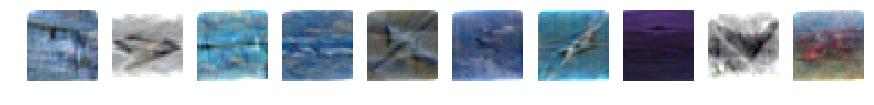

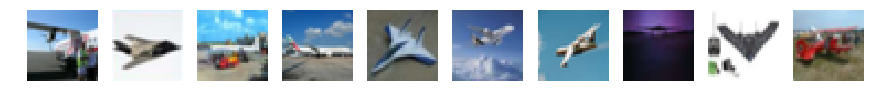

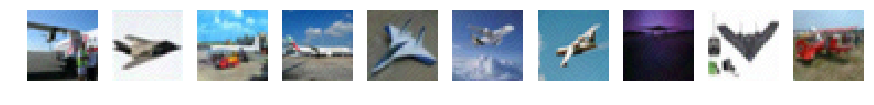

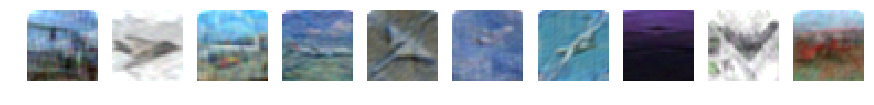

In [94]:
#Only constraint is small epsilon
visualize(clean_fgsm_test[0:10].reshape(-1,*input_shape), 10, '../figures/fgsm-clean-cifar_li')
visualize(reg_data[0:10].reshape(-1,*input_shape), 10, '../figures/fgsm-clean-cifar_li')
visualize(bim_data[0:10].reshape(-1,*input_shape), 10, '../figures/fgsm-clean-cifar_li')
visualize(clean_bim_test[0:10].reshape(-1,*input_shape), 10, '../figures/fgsm-clean-cifar_li')



In [91]:
print ('Model Accuracy Reconstructed BIM: %.5f' % (model.model.evaluate(clean_fgsm_test,model.test_labels[test_indices])[1]))

100/100 [==============================] - 0s 410us/step
Model Accuracy Reconstructed BIM: 0.44000


In [104]:
print ('Model Accuracy Reconstructed BIM: %.5f' % (model.model.evaluate(clean_bim_test,model.test_labels[test_indices])[1]))

100/100 [==============================] - 0s 260us/step
Model Accuracy Reconstructed BIM: 0.43000


In [71]:
#k=100
print ('Model Accuracy Reconstructed BIM: %.5f' % (model.model.evaluate(clean_fgsm_test,model.test_labels[test_indices])[1]))

100/100 [==============================] - 0s 249us/step
Model Accuracy Reconstructed BIM: 0.44000
